<a href="https://colab.research.google.com/github/maadhuvijay/Project-3-AI-Bootcamp/blob/main/Lego_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LEGO Brick Classifier

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import pickle


from PIL import Image
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

# Importing Data

In [2]:
"""
# Upload a ZIP File and Extract
from google.colab import files
uploaded = files.upload()

Saving data_modify.zip to data_modify.zip


In [3]:
"""
# Unzip the file

import zipfile
import imghdr

zip_file = "data_modify.zip"  # Change to your filename
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/images")  # Extract to 'images' folder



<ipython-input-3-ee6dba6141af>:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
"""

#Load images


image_folder = "/content/images/data_modify"
images = []


# Load images only if they are valid image files
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)

    # Check if the file is a valid image
    if os.path.isfile(file_path):
        # Check if the file is a valid image
        if imghdr.what(file_path):
            img = Image.open(file_path)  # Open the image using PIL

             #black back ground to white
            #image_array = np.array(img)
            #black_pixels = (image_array[:, :, :3] == 0).all(axis=-1)
            #image_array[black_pixels] = [255, 255, 255]
            #img = Image.fromarray(image_array)

            images.append(img)

print(f"Loaded {len(images)} images")




Loaded 1136 images


## Pickling the images

In [5]:
"""
# Mount the images to the drive

drive.mount('/content/drive')

# Open a new file named 'img.pkl' with write permission
with open('/content/drive/My Drive/img.pkl', 'wb') as file:
    # Use pickle.dump to store the list of images
    pickle.dump(images, file)

Mounted at /content/drive


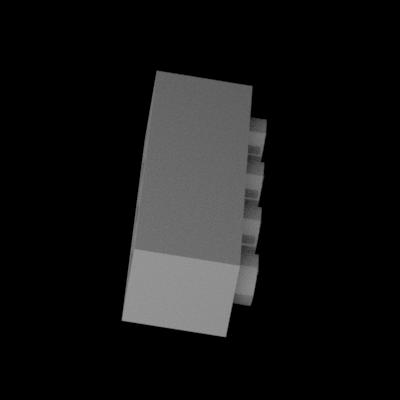

In [9]:
# Load the images from the pkl file
with open('/content/drive/My Drive/img.pkl', 'rb') as file:
    images = pickle.load(file)

images[900]

# Extract the file names

In [10]:
# Create a dataframe to store the file names from Images

file_names = []
# Walk through the directory and get all image filenames
for root, _, files in os.walk(image_folder):
    for filename in files:
        file_path = os.path.join(root, filename)

        # Append only image files
        if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
            file_names.append({"filename": filename})


# Convert to DataFrame
file_names=set(f["filename"] for f in file_names)
filename_df = pd.DataFrame(file_names, columns=['filename'])

# Display DataFrame
filename_df.head()  # Show first few rows

,filename
0,2357 brick corner 1x2x2 258L.png
1,2357 brick corner 1x2x2 078R.png
2,3001 brick 2x4 103L.png
3,3001 brick 2x4 078R.png
4,3010 brick 1x4 279R.png


In [11]:
# Check the shape of the dataframe

print(filename_df.shape)

(1136, 1)


## Data exploration

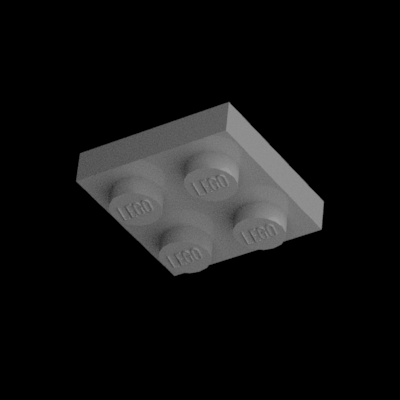

In [12]:
# Print a random image from the list to ensure the import was successful
images[400]

# Pre-processing Data

In [27]:
# Function to apply Fourier Transform to an image
def apply_fourier_transform(image):
    f = np.fft.fft2(image)  # Compute 2D Fourier Transform
    fshift = np.fft.fftshift(f)  # Shift zero frequency components to the center
    magnitude_spectrum = np.abs(fshift)  # Compute the magnitude spectrum
    normalized_spectrum = magnitude_spectrum / magnitude_spectrum.max()  # Normalize to range [0, 1]
    return normalized_spectrum

In [28]:
def preprocess_images(image_paths):
    transformed_images = []
    for img in images:
        #resized_img = cv2.resize(img, (250, 250))  # Resize to model input shape
        freq_img = apply_fourier_transform(img)  # Apply Fourier Transform
        transformed_images.append(freq_img)
    return np.array(transformed_images)

In [32]:
images=preprocess_images(images)

In [39]:
def resize_images(images, target_size=(250, 250)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)  # Resize to 250x250
        resized_images.append(resized_img)
    return np.array(resized_images)


In [33]:
# Check the size of an image
images[400].size

480000

In [34]:
# Check the pixel values of images

print(np.array(images[400]).min(), np.array(images[400]).max())

0.0 1.0


In [35]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes

{480000}

In [36]:
#Check the size of the images
print(type(images[1]))  # Should be a PIL Image

print(images[400].size)  # S

<class 'numpy.ndarray'>
480000


In [38]:
# Use a for loop to resize all images to 250 by 250
target_size = (250,250)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[400]

TypeError: 'resample' is an invalid keyword argument for this function

In [65]:
# Verify the resizing of all images
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in resized_images])
sizes

{(250, 250)}

In [66]:
# Check the image type and min/max values before conversion
print("Original image type:", type(resized_images[1]))  # Should be a PIL Image or numpy array
print("Original image size:", resized_images[1].size)  # Should show the dimensions
print("Original pixel range:")
print(np.array(resized_images[400]).min(), np.array(resized_images[400]).max())

Original image type: <class 'PIL.Image.Image'>
Original image size: (250, 250)
Original pixel range:
0 153


In [67]:
# Convert to NumPy array and then to float32


float_images = [np.array(img).astype(np.float32) for img in resized_images]
print("Pixel Values:")
#print(float_images[5][2])
print(np.array(float_images[400]).min(), np.array(float_images[400]).max())


Pixel Values:
0.0 153.0


In [68]:
#Enhance the images
enhanced_images = [((img - img.min()) / (img.max() - img.min())) * 255 for img in float_images]





In [18]:
#Adaptive Gamma correction
#gamma = 1.5  # Adjust as needed (higher = brighter)
#enhanced_images = [np.power(img / 255.0, gamma) * 255.0 for img in enhanced_images]

In [69]:
# Normalize pixel values to range [0, 1]
normalized_images = [img/255 for img in enhanced_images]
print("Pixel Values:")
#print(normalized_images[0])
print(np.array(normalized_images[400]).min(), np.array(normalized_images[400]).max())


Pixel Values:
0.0 1.0


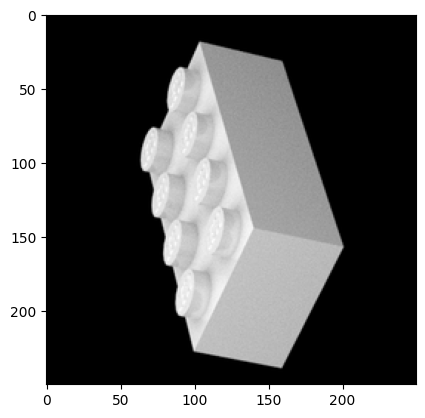

In [70]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(normalized_images[400])
plt.show()

In [71]:
#check the channel dimensions
normalized_images[400].shape

(250, 250, 3)

# Labels

In [72]:
filename_df.head()

,filename
0,3010 brick 1x4 132L.png
1,2357 brick corner 1x2x2 174R.png
2,3022 Plate 2x2 158L.png
3,3010 brick 1x4 171L.png
4,3010 brick 1x4 332L.png


In [73]:
print(filename_df.shape)

(1136, 1)


In [76]:
# Function to handle different filename structures
def split_filename(filename):
    parts = filename.replace('.png', '').split()  # Remove .png if needed and split by space
    design_id = parts[0]  # First part is the design ID
    image_id = parts[-1]  # Last part is the image ID
    element_size = parts[-2]  # Second last part is the element size
    element_name = " ".join(parts[1:-2])  # Everything in between is the element name
    return pd.Series([design_id, element_name, element_size, image_id])


# Apply function to DataFrame
filename_df[['design_id', 'element_name', 'element_size', 'image_#']] = filename_df['filename'].apply(split_filename)


filename_df.head()

,filename,design_id,element_name,element_size,image_#
0,3010 brick 1x4 132L.png,3010,brick,1x4,132L
1,2357 brick corner 1x2x2 174R.png,2357,brick corner,1x2x2,174R
2,3022 Plate 2x2 158L.png,3022,Plate,2x2,158L
3,3010 brick 1x4 171L.png,3010,brick,1x4,171L
4,3010 brick 1x4 332L.png,3010,brick,1x4,332L


In [77]:
filename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      1136 non-null   object
 1   design_id     1136 non-null   object
 2   element_name  1136 non-null   object
 3   element_size  1136 non-null   object
 4   image_#       1136 non-null   object
dtypes: object(5)
memory usage: 44.5+ KB


In [78]:
# Now we can call our preprocessed pixel data 'X'
X = normalized_images

# For our purposes, we'll select the userid column as 'y'
y = filename_df['design_id']

In [79]:
# Check the total number of classes
y.nunique()

4

In [80]:
# Get the actual class values
unique_classes = pd.Series(y).unique() # Convert y to a pandas Series
print(f"Unique class values: {unique_classes}")

Unique class values: ['3010' '2357' '3022' '3001']


In [81]:
y.shape

(1136,)

In [82]:
# Convert values to numpy arrays
X = np.array(X)
y = np.array(y)

In [83]:
# Now we'll split our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [84]:
y_test.shape

(284,)

In [85]:
X_train.shape

(852, 250, 250, 3)

In [86]:
y_train.shape

(852,)

## Checking if the length of training and testing data sets are same

In [87]:
# Print the length of each list
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

852
852
284
284


In [88]:
y_train.shape

(852,)

## Augmentation

In [37]:
"""
# Apply augmentation to the whole training dataset
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),         # Random rotation (20 degrees)
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Random horizontal and vertical shift
    tf.keras.layers.RandomZoom(0.2),             # Random zoom
    tf.keras.layers.RandomFlip('horizontal')     # Random horizontal flip
])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]

    # Add a channel dimension for grayscale images
    #img = np.expand_dims(img, axis=-1)  # Add channel dimension

    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 5 images for every original image
    for j in range(5):
        # Append a new image to the X list
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))

"""

"\n# Apply augmentation to the whole training dataset\n# Define the augmentation pipeline\ndata_augmentation = tf.keras.Sequential([\n    tf.keras.layers.RandomRotation(0.2),         # Random rotation (20 degrees)\n    tf.keras.layers.RandomTranslation(0.1, 0.1), # Random horizontal and vertical shift\n    tf.keras.layers.RandomZoom(0.2),             # Random zoom\n    tf.keras.layers.RandomFlip('horizontal')     # Random horizontal flip\n])\n\n# Create variables to hold the X and y training data\nX_train_aug = []\ny_train_aug = []\n\n# Loop through all the images.\nfor i in range(len(X_train)):\n    # Select the image\n    img = X_train[i]\n    # Select the label from the training data\n    label = y_train[i]\n\n    # Add a channel dimension for grayscale images\n    #img = np.expand_dims(img, axis=-1)  # Add channel dimension\n\n    # Ensure that the input data has the correct shape\n    img = np.expand_dims(img, axis=0)  # Add batch dimension\n\n    # Add 5 images for every original

In [71]:

"""
# Reshape test data for the model
X_test_np = []
for img in X_test:
    # Add a channel dimension for grayscale images
    #img = np.expand_dims(img, axis=-1)  # Add channel dimension
    # Append the image to the list
    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape
"""


(250, 250, 3)

# Creating the CNN Model

In [89]:
#One hot encode the y data
"""
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))
"""

y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train).reshape(-1, 1))
y_train_enc = y_encoder.transform(np.array(y_train).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))


In [90]:
# Convert values to numpy arrays
"""
#Augmentation code
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)
"""

#Without augmentation code
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train_enc)
y_test_np = np.array(y_test_enc)




In [91]:
X_train_np.shape

(852, 250, 250, 3)

In [92]:
X_test_np.shape

(284, 250, 250, 3)

In [93]:
y_train_np.shape

(852, 4)

In [94]:
y_test_np.shape

(284, 4)

In [149]:
#X_train_np = np.expand_dims(X_train_np[:, :, :, 0], axis=-1)
#X_test_np = np.expand_dims(X_test_np[:, :, :, 0], axis=-1)

In [95]:
X_train_np.shape

(852, 250, 250, 3)

In [96]:
X_test_np.shape

(284, 250, 250, 3)

In [97]:
y_train_np[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [102]:
# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_np, y_train_np, test_size=0.3, random_state=42)

In [111]:
from tensorflow.keras.initializers import HeNormal

# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(250, 250, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
     layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0005)),
    layers.Dense(4, activation='softmax')
])

# Compile the model
#model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=10,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model.evaluate(X_test_np, y_test_np)



Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.2574 - loss: 1.5515 - val_accuracy: 0.2109 - val_loss: 1.5070
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2932 - loss: 1.4894 - val_accuracy: 0.2461 - val_loss: 1.5016
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3606 - loss: 1.4469 - val_accuracy: 0.2500 - val_loss: 1.4979
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3279 - loss: 1.4556 - val_accuracy: 0.2383 - val_loss: 1.4946
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3660 - loss: 1.4272 - val_accuracy: 0.2383 - val_loss: 1.5043
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3514 - loss: 1.4301 - val_accuracy: 0.2461 - val_loss: 1.5018
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3886 - loss: 1.4042 - val_accuracy: 0.2422 - val_loss: 1.5003
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3899 - loss: 1.3957 - val_accuracy: 0.2383 - 

[1.4984008073806763, 0.26056337356567383]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2835 - loss: 1.4983


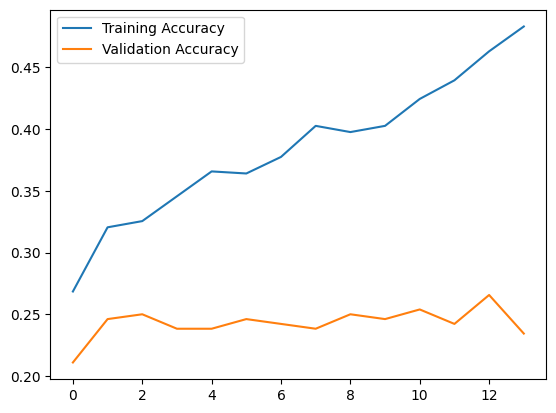

In [112]:
# Evaluate the model using the testing data
model.evaluate(X_test_np, y_test_np)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [113]:
model.save('lego2_mod.keras')

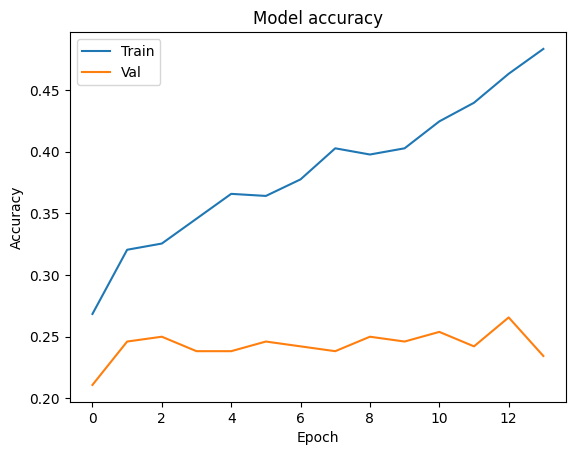

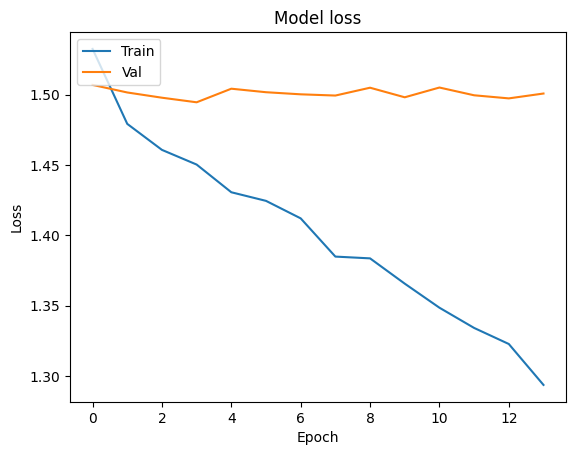

In [114]:
# Plot Model performance

import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Define the pre-trained ResNet50 Model

In [231]:
"""
# Define the Resnet Model

from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 Model
base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(250, 250, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build the new model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Replaces Flatten, prevents overfitting
    layers.Dense(128, activation='relu'),  # Adjust as needed
    layers.Dropout(0.5),  # Prevents overfitting
    layers.Dense(4, activation='softmax')  # 3 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 25
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs
)
# Print model summary
model.summary()

# Evaluate the model using the testing data
model.evaluate(X_test_np, y_test_np)
"""

Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 625ms/step - accuracy: 0.2354 - loss: 1.6350 - val_accuracy: 0.3086 - val_loss: 1.3881
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2276 - loss: 1.4370 - val_accuracy: 0.1953 - val_loss: 1.4147
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2430 - loss: 1.3987 - val_accuracy: 0.2656 - val_loss: 1.3923
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2916 - loss: 1.3846 - val_accuracy: 0.1875 - val_loss: 1.4006
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2614 - loss: 1.3854 - val_accuracy: 0.2305 - val_loss: 1.3905
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2431 - loss: 1.3853 - val_accuracy: 0.1953 - val_loss: 1.3926
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2868 - loss: 1.3828 - val_accuracy: 0.1953 - val_loss: 1.3953
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2769 - loss: 1.3811 - val_accuracy: 0.1953 -

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,376,078 (92.99 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,578 (2.00 MB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.2292 - loss: 1.3896


[1.3890846967697144, 0.23239436745643616]

## Hyperparamter tuning - Random search

In [163]:
"""
!pip install keras-tuner -q

import keras
from keras import layers
from keras_tuner import HyperModel, RandomSearch
import tensorflow as tf

# Define a model using HyperModel (used for hyperparameter tuning)
class CNNHyperModel(HyperModel):
    def build(self, hp):
        # Create a Sequential model
        model = keras.Sequential()

        # Hyperparameters for Conv2D layers
        model.add(layers.Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(250, 250, 3)
        ))
        model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Flatten())

        # Hyperparameter for Dense layer
        model.add(layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

        # Output layer
        model.add(layers.Dense(4, activation='softmax'))  # Binary classification

        # Compile the model
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model


# Instantiate the HyperModel
cnn_hypermodel = CNNHyperModel()

# Define the hyperparameter search
tuner = RandomSearch(
    cnn_hypermodel,
    objective='val_accuracy',  # We aim to optimize validation accuracy
    max_trials=5,               # Number of different hyperparameter combinations to test
    executions_per_trial=3,     # How many times to train each model
    directory='tuner_dir',      # Directory to save the results
    project_name='cnn_batch_tuning'  # Project name
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
best_model.evaluate(X_test_np, y_test_np)



"""

Trial 5 Complete [00h 01m 02s]
val_accuracy: 0.2630208333333333

Best val_accuracy So Far: 0.294921875
Total elapsed time: 00h 07m 30s
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2221 - loss: 2.0226


[1.9993237257003784, 0.22535210847854614]

In [164]:

# Print best hyperparameters
print("Best Hyperparameters Found:")
for param in best_hyperparameters.values:  # Use best_hyperparameters instead of best_hps
    print(f"{param}: {best_hyperparameters.get(param)}")

Best Hyperparameters Found:
conv_1_filters: 64
conv_2_filters: 96
dense_units: 96


## Classify the New LEGO images

In [120]:
"""
from google.colab import files
uploaded = files.upload()


img_path = "/content/0002.png"  # Assuming the image is named 0002.png
img1 = Image.open(img_path)
"""

'\nfrom google.colab import files\nuploaded = files.upload()\n\n\nimg_path = "/content/0002.png"  # Assuming the image is named 0002.png\nimg1 = Image.open(img_path) \n'

In [118]:


# Get the input image1 3001 brick
img_url=("https://images.brickset.com/parts/301002.jpg")

#img_path = "C:/Users/Owner/Git_Local/project3_prep/data_new/0002.png"
response=requests.get(img_url,stream=True).raw
img1=Image.open(response)
img1 = Image.open(BytesIO(response))
#img1 = Image.open(img_path)

#img1 = img1.convert('RGB')
img1=img1.resize((250,250))

plt.imshow(img1)
plt.show()

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7ed11d4d0860>

In [119]:



# Convert the image to grayscale
#img1 = img1.convert('L') # convert to grayscale

# Convert the image to a NumPy array and normalize pixel values
img1_array = np.array(img1).astype(np.float32) / 255.0
img1_array = img1_array.reshape(1, img1_array.shape[0], img1_array.shape[1], 3)  # Reshape for single image prediction

  #Predict image1

predict_img1 = model.predict(img1_array)
predicted_class = np.argmax(predict_img1)  # Get class index
#predicted_design_num = encoder.inverse_transform([predicted_class])

#print(img1_array)
print(predict_img1)
print(f"Lego pieces: {unique_classes}")
print (f"Predicted class: {unique_classes[predicted_class]}")
#print (f"Predicted design number: {predicted_design_num}")


NameError: name 'img1' is not defined

In [ ]:
# Since it's binary classification, check if the probability for class 1 is > 0.5
predicted_class = (predict_img1 > 0.5).astype(int)  # Convert to 0 or 1 based on the threshold

# Print the predicted class
print(f"Predicted class for the image: {predicted_class[0][0]}")

prob_class_0 = predict_img1[0][0]  # Probability for class 0
print(f"Probability of being a LEGO piece (Class 0): {prob_class_0}")

#Gradio application code

In [ ]:
!pip install gradio
!pip install pyttsx3
!sudo apt install espeak #Install espeak text-to-speech engine
!sudo apt install espeak-ng

In [ ]:
# Import Gradio
import gradio as gr
import pyttsx3



In [ ]:
#Initialize the TTS engine
engine=pyttsx3.init()

#Funciton to convert text to speech
def text_to_speech(text):
    engine.save_to_file(text,"output.wav")
    engine.runAndWait()
    return "output.wav"

In [ ]:
app = gr.Interface(
    fn=predict_design,
    inputs=gr.Image(type="pil"),  # Accepts image upload
    outputs=[gr.Textbox(label="Predicted Design ID")],  # Outputs text
)


In [ ]:
app.launch()